18.1 Form dollar bars on E-mini S&P 500 futures:

In [1]:
import pandas as pd
import numpy as np
import sqlite3

con=sqlite3.connect('../db/sp.db')
query="""SELECT * FROM sp WHERE "index" BETWEEN '2006-01-01' AND '2009-01-01'"""
df=pd.read_sql_query(query, con)
con.close()
df['index']=pd.to_datetime(df['index'])
df.set_index('index', inplace=True)
df.sort_index(inplace=True)
df['Close']=df['Close'].astype(float)
df['Volume']=df['Volume'].astype(float)

def get_dollar_bar(df:pd.DataFrame, threshold:float)->pd.DataFrame:
    df['dollar']= df['Close'] * df['Volume']
    start_idx=0
    current_dollar_sum = 0.0
    dollar_bar = []
    for i in range(len(df)):
        if current_dollar_sum + df['dollar'].iloc[i] >= threshold:
            bar={
                'Close': df['Close'].iloc[i],
                'Volume': df['Volume'].iloc[start_idx:i+1].sum(),
            }
            dollar_bar.append((df.index[i], bar))
            current_dollar_sum = 0.0
            start_idx = i + 1
        else:
            current_dollar_sum += df['dollar'].iloc[i]
    if current_dollar_sum > 0:
        bar = {
            'Close': df['Close'].iloc[-1],
            'Volume': df['Volume'].iloc[start_idx:].sum(),
        }
        dollar_bar.append((df.index[-1], bar))
    bar_df=pd.DataFrame.from_dict(dict(dollar_bar), orient='index')
    bar_df.index.name = 'index'
    return bar_df

total_trading_days=len(np.unique(df.index.date))
total_dollar=(df['Close']*df['Volume']).sum()
desired_bar_per_day=100
threshold=total_dollar / (total_trading_days * desired_bar_per_day)
dollar_bar_df=get_dollar_bar(df, threshold)
from statsmodels.tsa.stattools import adfuller
results = adfuller(dollar_bar_df['Close'])
print(f'ADF Statistic: {results[0]}')
print(f'p-value: {results[1]}')

ADF Statistic: -0.39640374830706887
p-value: 0.9106974932570443


(a) Quantize the returns series using binary Method

In [2]:
returns= dollar_bar_df['Close'].pct_change().dropna()
binary_encoding=returns[returns!=0]
binary_encoding = (binary_encoding > 0).astype(int)
print(binary_encoding.head())
print(binary_encoding.value_counts())

index
2006-01-02 17:05:10    1
2006-01-02 17:10:57    0
2006-01-02 17:19:28    0
2006-01-02 17:37:24    1
2006-01-02 18:15:12    1
Name: Close, dtype: int64
Close
1    36851
0    36432
Name: count, dtype: int64


(b) Quantize the returns series using the quantile encoding, using 10 letters 

In [3]:
sorted_return=returns.sort_values()

def get_fast_quantile(sorted_series: pd.Series, quantile: float) -> float:
    n = len(sorted_series)
    index=quantile * (n - 1)
    lower_index = int(np.floor(index))
    upper_index = int(np.ceil(index))
    weight = index - lower_index
    return (1-weight) * sorted_series.iloc[lower_index] + weight * sorted_series.iloc[upper_index]

quantiles=np.arange(0.01, 1.01, 0.01)
quantile_values = [get_fast_quantile(sorted_return, q) for q in quantiles]    
for i in range(1, len(quantiles)):
    sorted_return[(sorted_return >= quantile_values[i-1]) & (sorted_return < quantile_values[i])] = quantiles[i-1]

quantile_encoding = sorted_return.sort_index()
print(quantile_encoding.head())
print(quantile_encoding.value_counts())

index
2006-01-02 17:05:10    0.61
2006-01-02 17:10:57    0.30
2006-01-02 17:19:28    0.17
2006-01-02 17:37:24    0.92
2006-01-02 18:15:12    0.68
Name: Close, dtype: float64
Close
 0.550000    9731
 0.990000    6594
 0.590000     829
 0.290000     827
 0.620000     827
             ... 
-0.004394       1
-0.012380       1
-0.007268       1
-0.006075       1
-0.005491       1
Name: count, Length: 902, dtype: int64


(c) Quantize the returns series using the sigma encoding, where $\sigma$ is the standard deviation of all bar returns

In [4]:
sigma = np.std(returns)
min_return = returns.min()
max_return = returns.max()
encoding_val=0
sigma_encoding=pd.Series(np.nan, index=returns.index, dtype=float)
while max_return > min_return+(encoding_val+1)*sigma:
    sigma_encoding[(returns >= min_return + encoding_val * sigma) & (returns < min_return + (encoding_val + 1) * sigma)] = encoding_val
    encoding_val += 1
sigma_encoding[returns >= min_return + encoding_val * sigma] = encoding_val

print(sigma_encoding.head())
print(sigma_encoding.value_counts())

index
2006-01-02 17:05:10    52.0
2006-01-02 17:10:57    52.0
2006-01-02 17:19:28    52.0
2006-01-02 17:37:24    53.0
2006-01-02 18:15:12    52.0
dtype: float64
52.0    64839
53.0    12274
51.0     2620
54.0      981
50.0      555
        ...  
12.0        1
34.0        1
32.0        1
87.0        1
74.0        1
Name: count, Length: 65, dtype: int64


(d) Compute the entropy of the three encoded series, using the plug-in method.

In [5]:
def get_plug_in_entropy(series: pd.Series, window_length:int = 100) -> float:
    def get_probabilities(series: pd.Series, window_length:int=100) -> dict:
        probabilities = {}
        if not isinstance(series, str):
            series=''.join(series.astype(str))
        for i in range(window_length, len(series)):
            cur_window = series[i-window_length:i]
            if probabilities.get(cur_window) is None:
                probabilities[cur_window] = [i-window_length]
            else:
                probabilities[cur_window].append(i-window_length)
        ret=[]
        for i, (k, v) in enumerate(probabilities.items()):
            ret.append(len(v) / (len(series)-window_length))
        return ret
    probabilities = get_probabilities(series, window_length)
    entropy=-sum([p*np.log2(p) for p in probabilities])/window_length
    return entropy

binary_entropy = get_plug_in_entropy(binary_encoding, window_length=1000)
quantile_entropy = get_plug_in_entropy(quantile_encoding, window_length=1000)
sigma_entropy = get_plug_in_entropy(sigma_encoding, window_length=1000)
print(f'Binary Encoding Entropy: {binary_entropy}')
print(f'Quantile Encoding Entropy: {quantile_entropy}')
print(f'Sigma Encoding Entropy: {sigma_entropy}')
        

Binary Encoding Entropy: 0.016141368763910938
Quantile Encoding Entropy: 0.018755650444737218
Sigma Encoding Entropy: 0.01832663575724335


(e) Compute the entropy of the three encoded series, using Kontoyiannis's method, with a window size of 100.

In [6]:
def get_konto_entropy(series: pd.Series, window_length:int = None) -> float:
    if not isinstance(series, str):
        series = ''.join(series.astype(str))

    if window_length is None: # Expanding window method
        points=np.arange(1, len(series)//2+1)
    else: # sldiding window method
        window_length = min(window_length, len(series)//2)
        points= np.arange(window_length, len(series)-window_length)

    def get_max_match_length(msg:str, i:int, window_length:int) -> int:
        # Find the maximum length of a substring that matches with any previous substring
        if i < window_length:
            return 0
        
        max_length = 0
        for w in range(window_length):
            cur_msg=msg[i:i+w+1]
            for j in range(i-window_length, i):
                compare_msg = msg[j:j+w+1]
                if cur_msg == compare_msg:
                    max_length = w
                    break
        return max_length    
    
    entropy=0
    for i in points:
        if window_length is None:
            max_match_length = get_max_match_length(series, i, i)
            entropy+=np.log2(i)/(1+max_match_length)
        else:
            max_match_length = get_max_match_length(series, i, window_length)
            entropy+=np.log2(window_length)/(1+max_match_length)
    return entropy / len(points)

binary_konto_entropy = get_konto_entropy(binary_encoding, window_length=100)
quantile_konto_entropy = get_konto_entropy(quantile_encoding, window_length=100)
sigma_konto_entropy = get_konto_entropy(sigma_encoding, window_length=100)
print(f'Binary Encoding Konto Entropy: {binary_konto_entropy}')
print(f'Quantile Encoding Konto Entropy: {quantile_konto_entropy}')
print(f'Sigma Encoding Konto Entropy: {sigma_konto_entropy}')

   
    

Binary Encoding Konto Entropy: 1.0146345752052923
Quantile Encoding Konto Entropy: 2.1734791291774815
Sigma Encoding Konto Entropy: 0.4749401632821323


18.2 Using the bars from exercise 1:

(a) Compute the returns series, $\{r_t\}$.

(b) Encode the series as follows $e_t=\begin{cases}0\ if\ r_tr_{t-1}<0 \\ 1\ if\ r_tr_{t-1} \ge 0\end{cases}$

In [15]:
encoder=(returns*returns.shift(1)).dropna().apply(lambda x: 1 if x >= 0 else 0)


(c) Partition the series into 1000 non-overlapping subsets of equal size (you may have to drop some observations at the beginning.)

In [16]:
div_size=100
encoder_length = len(encoder)
drop_length=encoder_length%div_size
encoder = encoder.iloc[:-drop_length] if drop_length > 0 else encoder
encoder = encoder.values.reshape(-1, div_size)
encoder = pd.DataFrame(encoder, columns=[f'col_{i}' for i in range(encoder.shape[1])])


(d) Compute the entropy of each of the 1000 encoded subsets,using the plug-
in method.

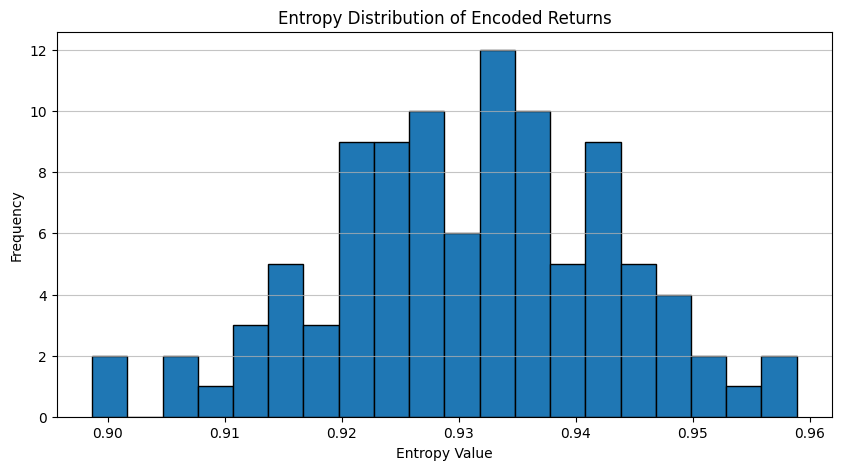

In [19]:
plug_in_entropy_values = []
for col in encoder.columns:
    encoder[col] = encoder[col].astype(int)
    entropy= get_plug_in_entropy(encoder[col], window_length=encoder.shape[0]//100)
    plug_in_entropy_values.append(entropy)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(plug_in_entropy_values, bins=20, edgecolor='black')
plt.title('Entropy Distribution of Encoded Returns')
plt.xlabel('Entropy Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

(e) Compute the entropy of each of the 1000 encoded subsets,using the Kon
toyiannis method, with a window size of 100

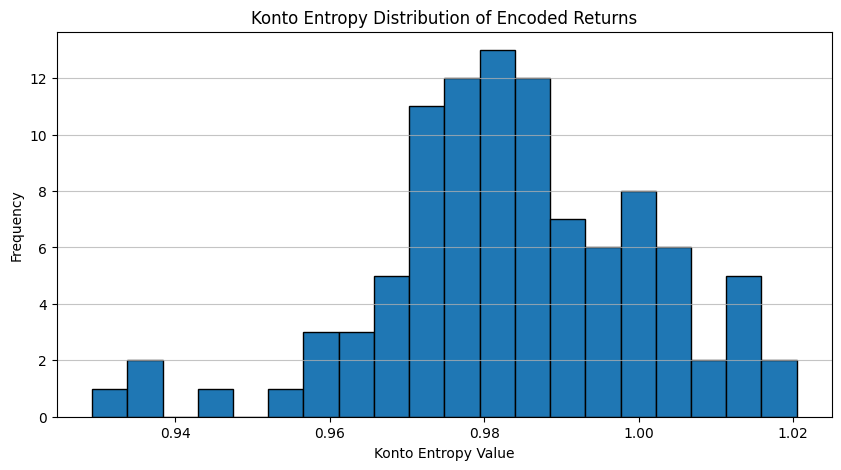

In [20]:
konto_entropy_values=[]
for col in encoder.columns:
    encoder[col] = encoder[col].astype(int)
    entropy = get_konto_entropy(encoder[col], window_length=100)
    konto_entropy_values.append(entropy)

plt.figure(figsize=(10, 5))
plt.hist(konto_entropy_values, bins=20, edgecolor='black')
plt.title('Konto Entropy Distribution of Encoded Returns')
plt.xlabel('Konto Entropy Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

(f) Compute the correlation between results2.d and 2.e.

In [21]:
print('Correlation between Plug-in Entropy and Konto Entropy:', np.corrcoef(plug_in_entropy_values, konto_entropy_values)[0, 1])

Correlation between Plug-in Entropy and Konto Entropy: 0.6455978926884962


18.3 Draw 1000 observations fromastandard Normal distribution:

In [23]:
test_series=pd.Series(np.random.randn(1000))

(a) What is the true entropy of this process?

In [31]:
from scipy.stats import norm
entorpy=0.5*np.log(2*np.pi*np.e*np.var(test_series))
print(f'Entropy of test series: {entorpy}')

Entropy of test series: 1.3885855056048833


(b) Label the observations according to 8 quantiles.

In [32]:
sorted_test_series=test_series.sort_values()
quantile=np.arange(1/8, 1.01, 1/8)
quantile_values = [get_fast_quantile(sorted_test_series, q) for q in quantile]
for i in range(1, len(quantile)):
    sorted_test_series[(sorted_test_series >= quantile_values[i-1]) & (sorted_test_series < quantile_values[i])] = quantile[i-1]
quantile_encoding_test = sorted_test_series.sort_index()
print(quantile_encoding_test.head())
print(quantile_encoding_test.value_counts())

0    0.625
1    0.625
2    0.625
3    0.625
4    0.625
dtype: float64
 0.625000    625
 0.750000    125
 0.875000    124
-1.189591      1
-1.695917      1
            ... 
-1.169346      1
-1.265952      1
-1.353719      1
-1.189294      1
-1.185389      1
Name: count, Length: 129, dtype: int64


(c) Estimate the entropy using the plug-in method.

In [33]:
plug_in_test_entropy = get_plug_in_entropy(quantile_encoding_test, window_length=100)

(d) Estimate the entropy using the Kontoyiannis method:   
(i) using a window size of 10.   
(ii) using a window size of 100.   

In [34]:
konto_test_entropy_10 = get_konto_entropy(quantile_encoding_test, window_length=10)
konto_test_entropy_100 = get_konto_entropy(quantile_encoding_test, window_length=100)
print(f'Plug-in Entropy of Test Series: {plug_in_test_entropy}')
print(f'Konto Entropy of Test Series (window_length=10): {konto_test_entropy_10}')
print(f'Konto Entropy of Test Series (window_length=100): {konto_test_entropy_100}')

Plug-in Entropy of Test Series: 0.12666002032646234
Konto Entropy of Test Series (window_length=10): 2.0100665695165114
Konto Entropy of Test Series (window_length=100): 2.4614490004615384


18.4 Using the draws from exercise 3, $\{x_t\}_{t=1,...,1000}$

(a) Compute the $y_t=\rho y_{t-1}+x_t$ where $\rho=0.5, y_0=0$

In [35]:
p=0.5
y_list=[0]
for i in range(test_series.shape[0]):
    y_new=p*y_list[-1]+test_series.iloc[i]
    y_list.append(y_new)

(b) Label $\{y_t\}$ the observations according to 8 quantiles

In [36]:
sorted_y_series=pd.Series(y_list).sort_values()
quantile_y=np.arange(1/8, 1.01, 1/8)
quantile_y_values = [get_fast_quantile(sorted_y_series, q) for q in quantile_y]
for i in range(1, len(quantile_y)):
    sorted_y_series[(sorted_y_series >= quantile_y_values[i-1]) & (sorted_y_series < quantile_y_values[i])] = quantile_y[i-1]
quantile_y_encoding = sorted_y_series.sort_index()
print(quantile_y_encoding.head())

0    0.625000
1    0.625000
2    0.625000
3    0.625000
4   -1.362878
dtype: float64


(c) Estimate the entropy using the plug-in method

In [37]:
plug_in_y_entropy = get_plug_in_entropy(quantile_y_encoding, window_length=100)

(d) Estimate the entropy using the Kontoyiannis method:   
(i) using a window size of 10.   
(ii) using a window size of 100.   

In [38]:
konto_y_entropy_10 = get_konto_entropy(quantile_y_encoding, window_length=10)
konto_y_entropy_100 = get_konto_entropy(quantile_y_encoding, window_length=100)
print(f'Plug-in Entropy of Y Series: {plug_in_y_entropy}')
print(f'Konto Entropy of Y Series (window_length=10): {konto_y_entropy_10}')
print(f'Konto Entropy of Y Series (window_length=100): {konto_y_entropy_100}')

Plug-in Entropy of Y Series: 0.1266666784068918
Konto Entropy of Y Series (window_length=10): 1.9364625485507503
Konto Entropy of Y Series (window_length=100): 2.4451977269851226


18.5 Suppose a portfolio of 10 holdings with equal dollar allocations

(a) The portion of the total risk contributed by the ith principal component is
$\frac{1}{10}\ i= 1,…,10.$. What is the portfolio’s entropy?

실제 계산상으로는 0이여야한다.

In [ ]:
def get_portfolio_entropy(risk_contributions: np.ndarray)-> float:
   portfolio_concentration=-np.sum(risk_contributions * np.log(risk_contributions))
   return 1-(1/len(risk_contributions)) * np.exp(portfolio_concentration)

risk_contributions = np.array([0.1]*10)
portfolio_entropy = get_portfolio_entropy(risk_contributions)
print(f'Portfolio Entropy: {portfolio_entropy}')

Portfolio Entropy: 1.1102230246251565e-16


(b) The portion of the total risk contributed by the ith principal component is
$1-\frac{i}{55}, i= 1,…,10$. What is the portfolio’s entropy?

In [40]:
risk_contributions=np.array([1-i/55 for i in range(1, 11)])
portfolio_entropy = get_portfolio_entropy(risk_contributions)
print(f'Portfolio Entropy with Decreasing Risk Contributions: {portfolio_entropy}')

Portfolio Entropy with Decreasing Risk Contributions: 0.7457677623500972


(c) The portion of the total risk contributed by the ith principal components is
$\alpha\frac{1}{10}+(1-\alpha)(1-\frac{i}{55})\ i= 1,…,10, \alpha \in [0,1]$
Plot the portolio’s entropy as a function of $\alpha$

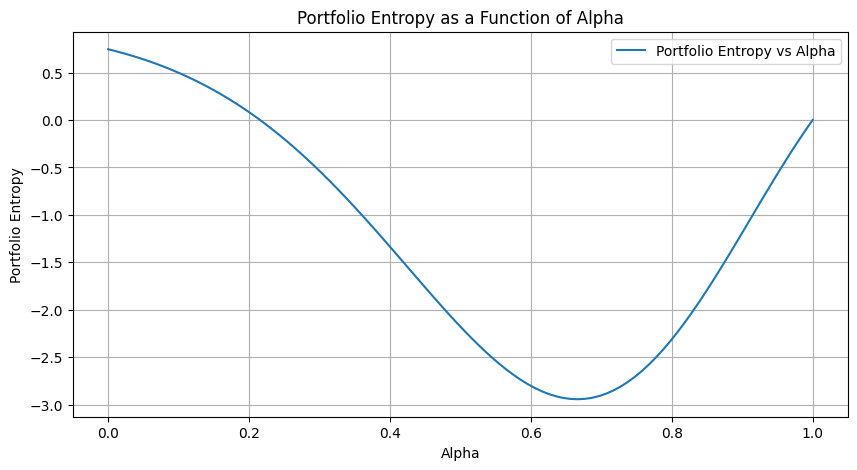

In [43]:
alphas=np.linspace(0.0, 1.0,100)
entropy_list = []
for alpha in alphas:
    risk_contributions = np.array([alpha * 1/10 + (1 - alpha) * (1-(i/55)) for i in range(1, 11)])
    portfolio_entropy = get_portfolio_entropy(risk_contributions)
    entropy_list.append(portfolio_entropy)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(alphas, entropy_list, label='Portfolio Entropy vs Alpha')
plt.title('Portfolio Entropy as a Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Portfolio Entropy')
plt.grid()
plt.legend()
plt.show()
